# Calculating the Climatological and Anomaly Values for Selected CBP Stations

## Notebook Overview
- Select Chesapeake Bay Program (CBP) stations with sufficient SST observation temporal coverage at the appropriate depths to compute a climatology.
- Extract one SST value at each location and day, if there are observations at multiple depths.
- Compute the seasonal climatology of the mixed layer from the chosen stations.
- Compute the observed SST anomalies.
- Save the observed SST values, the climatological value, and the observed SST anomaly for location and observation day.

### Supplemental information
- [Chesapeake Bay Program station names](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/map_of_mainstem_and_tributary_monitoring_stations.pdf)
- [Chesapeake Bay Program data guide](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)

## Analysis

In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

Update the `REPO_ROOT` to the location of the `journalarticle_chesapeake_mhw` folder on your machine.

In [2]:
SAVE_FIGS = True
REPO_ROOT = Path('/Users/rwegener/repos/journalarticle_chesapeake_mhw')

### Read Data

In [3]:
# Read the csv into a pandas dataframe
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
path = REPO_ROOT / 'data/01_raw/WaterQuality_ChesapeakeBayProgram_20030101_20231231_Temp.csv'
wq = pd.read_csv(path, usecols=cols, parse_dates=[2])

### Filter, Average, and Save Raw SST Observations

In [4]:
# Only consider measurements between 1 and 3 meters depth
wq_stations = wq[(wq.Depth > 1) & (wq.Depth < 3)]

In [5]:
# Take average value of observations at those depths
wq_stations = wq_stations.groupby(['Station', 'SampleDate']).mean(numeric_only=True).reset_index()

In [6]:
# Clean un-needed columns
wq_stations = wq_stations.drop(['EventId', 'Depth'], axis=1)
wq_stations = wq_stations.rename(columns={'MeasureValue': 'sst_cbp'})

File has one SST value per lat/lon/date. Values are the average of all the observations between 1m and 3m depth.

In [8]:
# Save output
output_dir = REPO_ROOT / 'data/02_interim'
wq_stations.to_csv(
    output_dir / 'cbp_sst_depthaveraged.csv', 
    index=False
)

In [9]:
wq_stations

,Station,SampleDate,sst_cbp,Latitude,Longitude
0,1AAUA001.39,2007-03-22,8.3,38.4000,-77.3200
1,1AAUA001.39,2007-06-18,26.2,38.4000,-77.3200
2,1AAUA001.39,2007-10-29,14.5,38.4000,-77.3200
3,1AAUA001.39,2007-12-10,5.2,38.4000,-77.3200
4,1AAUA001.39,2008-02-04,4.9,38.4000,-77.3200
...,...,...,...,...,...
53387,ZDM0003,2004-07-08,27.7,38.9362,-76.5067
53388,ZDM0003,2004-08-05,29.0,38.9362,-76.5067
53389,ZDM0003,2004-08-19,26.4,38.9362,-76.5067
53390,ZDM0003,2004-09-15,24.5,38.9362,-76.5067


### Preprocessing

In [10]:
# Create a list of all the station names
stations = wq_stations.groupby('Station').count().index

In [11]:
# Create a dataframe with the number of observations per station and month
counts = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]).count()['sst_cbp']
# Format the dataframe more clearly
counts = pd.DataFrame(counts)
counts = counts.rename(columns={'sst_cbp': 'ObsCount'})
counts.index = counts.index.set_names(['Station', 'year', 'month'])

### Create a list of stations that have enough data to compute a climatology

Create a filtered list of stations that have at least 12 years of observations in all months and 18 observations in 10 of the months.

In [12]:
stations_filtered = []  # TODO rename to clim_elibigle_stations
completeness_df = pd.DataFrame(
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
               'Nov', 'Dec']
)

for station in stations:
    # extract station
    df = counts.loc[station]
    # preprocessing
    df = df.reset_index()
    matrix = df.pivot(index='year', columns='month')
    
    # Add to filtered stations if it meets the condition
    if (matrix.sum() < 12).sum() > 0:
        # If any month does not have at least 12 years with an obs (~60% coverage)
        # do not consider it
        continue
    # Check that there are at least 18 months with obs (~90% coverage) in 10 of the months
    if ((~matrix.isna()).sum() >= 18).sum() >= 10:
        stations_filtered.append(station)
        # optional - plot a heatmap for the individual station
        # sns.heatmap(matrix)
        # plt.title(station)
        # plt.show()
        # plt.close()
        completeness_df.loc[station] = (~matrix.isna()).sum().values

print(len(stations_filtered), 'stations identified.')

60 stations identified.


### Filter stations list to only include climatology-eligible stations

In [13]:
wq_stations = wq_stations[wq_stations.Station.isin(stations_filtered)]

### Plot location of the climatology stations

In [14]:
wq_counts = wq_stations.groupby('Station').mean(numeric_only=True)[['Latitude', 'Longitude']]
wq_counts['Count'] = wq_stations.groupby('Station').count()['sst_cbp']

In [15]:
geoWQ = gpd.GeoDataFrame(
    wq_counts, geometry=gpd.points_from_xy(wq_counts['Longitude'], wq_counts['Latitude']), 
    crs='epsg:4326')

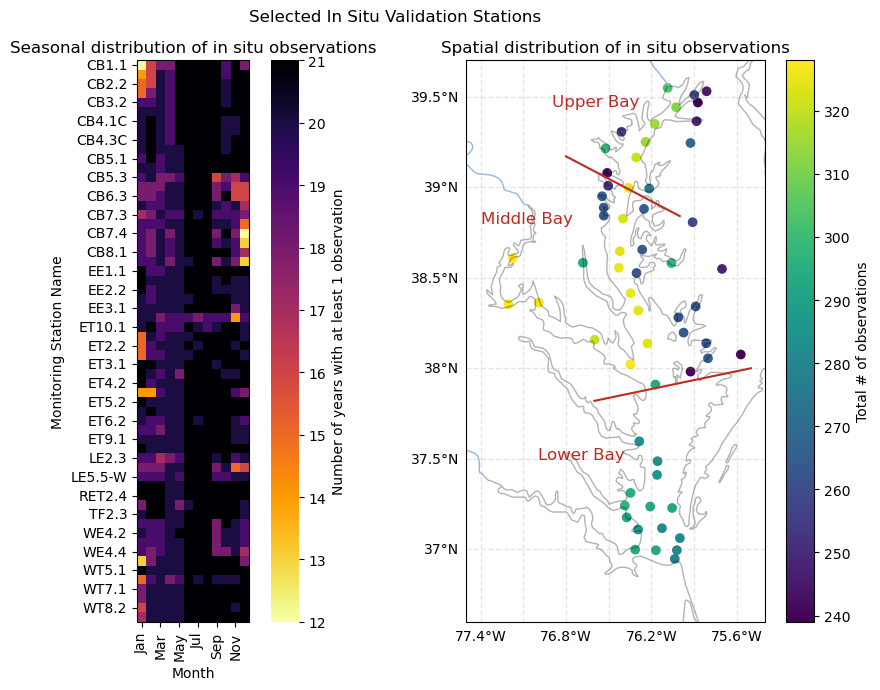

In [18]:
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, 
                         # gridspec_kw={'width_ratios':[5, 2]}, 
                         figsize=(10, 7))
                        # gridspec_kw={'width_ratios':[2, 1]})  # , 'height_ratios':[2,1]})
fig.suptitle('Selected In Situ Validation Stations')

# fig.set_size_inches(9, 6)
# fig.suptitle('Locations of most frequently sampled in situ locations')

# Add background features
axes[1].add_feature(cfeature.COASTLINE, alpha=0.3)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].add_feature(cfeature.RIVERS)
# ax.coastlines()

axes[1].set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

# Add seasonal distribution
# attempted and failed to make colorbar discrete
# making colorbar discrete is fine; struggling with label location
# cmap = plt.get_cmap('inferno_r', np.max(completeness_df.values) - np.min(completeness_df.values) + 1)
axes[0].set_title('Seasonal distribution of in situ observations')
sns.heatmap(completeness_df, ax=axes[0], cmap='inferno_r',
                   # linewidths=0.2,
            cbar_kws={'label': 'Number of years with at least 1 observation'})
axes[0].set_ylabel('Monitoring Station Name')
axes[0].set_xlabel('Month')
axes[0].set_xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5])
axes[0].set_xticklabels(['Jan','Mar','May','Jul', 'Sep', 'Nov'])

# Plot in situ locations
axes[1].set_title('Spatial distribution of in situ observations')
geoWQ.plot(ax=axes[1], column='Count', legend=True, legend_kwds={'label': "Total # of observations"})
# Add upper / middle / lower locations
axes[1].plot([-76.8, -76.0], [39.17, 38.84], color='#bd2b20')  # upper/mid
axes[1].plot([-76.6, -75.5], [37.82, 38], color='#bd2b20')  # mid/lower
axes[1].text(-76.9, 39.45, 'Upper Bay', color='#bd2b20', size=12)
axes[1].text(-77.4, 38.8, 'Middle Bay', color='#bd2b20', size=12)
axes[1].text(-77.0, 37.5, 'Lower Bay', color='#bd2b20', size=12)


plt.tight_layout()

if SAVE_FIGS: 
    output_dir = REPO_ROOT / 'figures/02_validation'
    plt.savefig(output_dir / 'insitu_distribution.png', 
                dpi=400, bbox_inches='tight')

**Most sampled stations from several areas of the bay**

- CB5.1 -- main stem outside the Patuxent River
- RET2.4 -- up the Potomac River
- CB7.2 -- main stem near the exit of the Bay

In [19]:
len(stations_filtered)

60

## Compute the Climatologial Value for each Depth and Location

In [20]:
wq_stations.sort_values(['Station', 'SampleDate'])

,Station,SampleDate,sst_cbp,Latitude,Longitude
1335,CB1.1,2003-01-15,1.10,39.54794,-76.08481
1336,CB1.1,2003-03-12,2.40,39.54794,-76.08481
1337,CB1.1,2003-04-09,6.90,39.54794,-76.08481
1338,CB1.1,2003-04-23,12.40,39.54794,-76.08481
1339,CB1.1,2003-05-07,18.10,39.54794,-76.08481
...,...,...,...,...,...
42477,WT8.3,2023-08-08,27.40,38.84250,-76.53410
42478,WT8.3,2023-09-13,27.80,38.84250,-76.53410
42479,WT8.3,2023-10-17,16.75,38.84250,-76.53410
42480,WT8.3,2023-11-16,11.10,38.84250,-76.53410


In [21]:
# Determine how many observations there are for each station in each month/year
counts = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]
).count()['sst_cbp']
counts = pd.DataFrame(counts)
counts = counts.rename({'sst_cbp': 'ObsCount'}, axis=1)
counts.index = counts.index.set_names(['Station', 'year', 'month'])

In [23]:
wq_stations[['Station', 'SampleDate']].to_csv(
    REPO_ROOT / 'data/02_interim' / 'climatology_station_dates.csv',
    index=False,
)

In [24]:
wq_clim = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.month]
)['sst_cbp'].mean(numeric_only=True)

In [25]:
wq_clim = wq_clim.dropna().sort_index().reset_index()  \
    .rename(columns={'SampleDate': 'Month', 'sst_cbp': 'clim_cbp'})

## Compute Anomalies

In [26]:
wq_stations['Month'] = wq_stations.SampleDate.dt.month

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2363/3673797116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wq_stations['Month'] = wq_stations.SampleDate.dt.month


In [27]:
wq.sort_values(['Station', 'SampleDate'])

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
247040,409036.0,01491000,2011-10-12,09:00:00,0.0,VH,17.4,DEG C,38.99722,-75.78611
248942,409037.0,01491000,2011-11-07,11:00:00,0.0,VH,9.0,DEG C,38.99722,-75.78611
250682,409038.0,01491000,2011-12-01,10:30:00,0.0,VH,9.0,DEG C,38.99722,-75.78611
251037,409039.0,01491000,2011-12-08,11:30:00,0.0,VH,10.8,DEG C,38.99722,-75.78611
252632,409040.0,01491000,2012-01-09,10:30:00,0.0,VH,5.1,DEG C,38.99722,-75.78611
...,...,...,...,...,...,...,...,...,...,...
41940,38803.0,ZDM0003,2004-10-13,09:26:00,1.5,M,17.0,DEG C,38.93620,-76.50670
42001,38803.0,ZDM0003,2004-10-13,09:26:00,0.5,BS,17.5,DEG C,38.93620,-76.50670
42002,38803.0,ZDM0003,2004-10-13,09:26:00,1.0,M,17.3,DEG C,38.93620,-76.50670
43028,39089.0,ZDM0003,2004-10-27,09:05:00,1.0,M,15.3,DEG C,38.93620,-76.50670


In [28]:
wq_clim

,Station,Month,clim_cbp
0,CB1.1,1,4.050000
1,CB1.1,2,2.943750
2,CB1.1,3,5.750000
3,CB1.1,4,12.520000
4,CB1.1,5,18.532143
...,...,...,...
715,WT8.3,8,27.191667
716,WT8.3,9,23.715217
717,WT8.3,10,17.254167
718,WT8.3,11,10.961905


In [29]:
wq = pd.merge(wq_stations, wq_clim, on=['Station', 'Month'])  \
    .drop(columns=['Month'])

In [30]:
wq['anom_cbp'] = wq['sst_cbp'] - wq['clim_cbp']

In [31]:
# Rearrange columns for neatness
anom_cbp = wq.pop('anom_cbp')
wq.insert(3, anom_cbp.name, anom_cbp)

In [32]:
wq.sort_values(['Station', 'SampleDate']).reset_index(drop=True)

,Station,SampleDate,sst_cbp,anom_cbp,Latitude,Longitude,clim_cbp
0,CB1.1,2003-01-15,1.10,-2.950000,39.54794,-76.08481,4.050000
1,CB1.1,2003-03-12,2.40,-3.350000,39.54794,-76.08481,5.750000
2,CB1.1,2003-04-09,6.90,-5.620000,39.54794,-76.08481,12.520000
3,CB1.1,2003-04-23,12.40,-0.120000,39.54794,-76.08481,12.520000
4,CB1.1,2003-05-07,18.10,-0.432143,39.54794,-76.08481,18.532143
...,...,...,...,...,...,...,...
17121,WT8.3,2023-08-08,27.40,0.208333,38.84250,-76.53410,27.191667
17122,WT8.3,2023-09-13,27.80,4.084783,38.84250,-76.53410,23.715217
17123,WT8.3,2023-10-17,16.75,-0.504167,38.84250,-76.53410,17.254167
17124,WT8.3,2023-11-16,11.10,0.138095,38.84250,-76.53410,10.961905


In [33]:
# Save data
path = (
    REPO_ROOT / 
    'data/02_interim' /  
    'cbp_ssta_selected_stations_with_climatology.csv'
)
wq.to_csv(path, index=False)